In [1]:
# ==== 基础函数与 pseudo-bulk 基线 ====
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from scipy.optimize import nnls
import scanpy as sc
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

# ================== 1. 读取数据 (修改后) ==================
scRNA = sc.read_h5ad("../scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad")
ST = sc.read_h5ad("../scvi-tools-DestVI/data/st_lymph_node_preprocessed.h5ad")

# 统一基因集
genes = scRNA.var_names.intersection(ST.var_names)
scRNA = scRNA[:, genes].copy()
ST = ST[:, genes].copy()
print("genes count:", len(genes))

# --- 为 ZINB-VAE 准备原始计数数据 ---
# 直接从 .layers['counts'] 中提取原始计数矩阵
# 这是将要用于训练 VAE 的数据
if "counts" in scRNA.layers:
    counts_layer = scRNA.layers["counts"]
    # 如果是稀疏矩阵，先转为稠密
    if hasattr(counts_layer, "toarray"):
        sc_counts_raw = counts_layer.toarray()
    else:
        sc_counts_raw = np.asarray(counts_layer)
else:
    sc_counts_raw = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
X_sc_counts = torch.tensor(np.asarray(sc_counts_raw), dtype=torch.float32).to(device)


# --- 为 GCN 准备归一化+对数变换的数据 ---
# 这里的逻辑保持不变，确保 scRNA.X 和 ST.X 是归一化和log变换后的版本
def _is_log_transformed(adata):
    X = adata.X
    # 稀疏矩阵转稠密
    if hasattr(X, "toarray"):
        arr = X.toarray()
    elif hasattr(X, "A"):
        arr = X.A
    else:
        arr = np.asarray(X)
    if arr.size == 0:
        return False
    if np.nanmax(arr) > 100:
        return False
    return True

for name, ad in (("scRNA", scRNA), ("ST", ST)):
    # 先转为稠密 numpy 数组
    if hasattr(ad.X, "toarray"):
        X_curr = ad.X.toarray()
    elif hasattr(ad.X, "A"):
        X_curr = ad.X.A
    else:
        X_curr = np.asarray(ad.X)
    print(f"{name}: current ad.X max={np.nanmax(X_curr):.4f}")
    if _is_log_transformed(ad):
        print(f"{name}: appears already log-transformed, skipping normalize/log1p (max={np.nanmax(X_curr):.4f})")
    else:
        mat = ad.layers["counts"] if "counts" in ad.layers else ad.X
        if hasattr(mat, "toarray"):
            mat = mat.toarray()
        elif hasattr(mat, "A"):
            mat = mat.A
        else:
            mat = np.asarray(mat)
        ad.X = mat  # 使用原始计数进行后续处理
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        print(f"{name}: applied normalize_total + log1p (new max={np.nanmax(ad.X):.4f})")

# 从处理后的 AnnData 对象中提取归一化数据
if hasattr(scRNA.X, "toarray"):
    X_sc_normalized = scRNA.X.toarray()
elif hasattr(scRNA.X, "A"):
    X_sc_normalized = scRNA.X.A
else:
    X_sc_normalized = np.asarray(scRNA.X)
X_sc_normalized = X_sc_normalized.astype(np.float32)

if hasattr(ST.X, "toarray"):
    X_st_normalized = ST.X.toarray()
elif hasattr(ST.X, "A"):
    X_st_normalized = ST.X.A
else:
    X_st_normalized = np.asarray(ST.X)
X_st_normalized = X_st_normalized.astype(np.float32)

# 将归一化数据转为 Tensor
X_sc = torch.tensor(np.asarray(X_sc_normalized), dtype=torch.float32).to(device)
X_st = torch.tensor(np.asarray(X_st_normalized), dtype=torch.float32).to(device)

# 标签信息
labels = scRNA.obs["broad_cell_types"].astype("category").cat.codes.values
labels = torch.tensor(labels, dtype=torch.long)

# 打印最终形状，确认一致性
print("\n--- Final Tensor Shapes ---")
print("X_sc_counts (for VAE training):", X_sc_counts.shape)
print("X_sc (normalized, for GCN 'E' profile):", X_sc.shape)
print("X_st (normalized, for GCN input 'Y'):", X_st.shape)

celltypes = scRNA.obs["broad_cell_types"].astype("category").cat.categories.tolist()

使用设备: cuda
genes count: 1888
scRNA: current ad.X max=11.3014
scRNA: appears already log-transformed, skipping normalize/log1p (max=11.3014)
ST: current ad.X max=7.7890
ST: appears already log-transformed, skipping normalize/log1p (max=7.7890)

--- Final Tensor Shapes ---
X_sc_counts (for VAE training): torch.Size([14989, 1888])
X_sc (normalized, for GCN 'E' profile): torch.Size([14989, 1888])
X_st (normalized, for GCN input 'Y'): torch.Size([1092, 1888])


In [8]:


# 1. 构建 pseudo-bulk 参考表达 (与当前 ST/scRNA 基因集一致)
# 使用归一化+log1p 后的 scRNA.X (与你当前 GCN 重建域一致)
# celltypes / scRNA 已存在
gene_names = np.array(scRNA.var_names)
type_codes = scRNA.obs["broad_cell_types"].astype("category").cat.codes.values
n_types = len(celltypes)
X_sc_log = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X  # log1p normalized
E_simple = np.zeros((n_types, X_sc_log.shape[1]), dtype=np.float32)
for i in range(n_types):
    mask = (type_codes == i)
    if mask.sum() > 0:
        E_simple[i] = X_sc_log[mask].mean(0)
# 保持与 E_simple 后续运算的数值稳定：再做一个很小的裁剪
E_simple = np.clip(E_simple, 0, None)

# 2. NNLS 解混 (逐 spot)
# y (1 x G) 近似为 w (1 x K) * E_simple (K x G)
if hasattr(ST.X, "toarray"):
    X_st_log = ST.X.toarray()
elif hasattr(ST.X, "A"):
    X_st_log = ST.X.A
else:
    X_st_log = np.asarray(ST.X)
X_st_log = X_st_log.astype(np.float32)  # 保证为float稠密矩阵

W_nnls = np.zeros((X_st_log.shape[0], n_types), dtype=np.float32)
E_T = E_simple.T  # (G, K)
for s in range(X_st_log.shape[0]):
    coeffs, _ = nnls(E_T, X_st_log[s])
    if coeffs.sum() > 0:
        coeffs = coeffs / coeffs.sum()
    W_nnls[s] = coeffs

# 3. 用 W_nnls 与 E_simple 重建
X_recon_nnls = W_nnls @ E_simple   # (spots, genes)

# 4. 评估函数
def evaluate_reconstruction(X_true, X_pred, gene_names, tag):
    # 全局
    r2_global = r2_score(X_true.reshape(-1), X_pred.reshape(-1))
    # 基因维度 R2
    gene_r2 = []
    for g in range(X_true.shape[1]):
        try:
            r2g = r2_score(X_true[:, g], X_pred[:, g])
        except ValueError:
            r2g = np.nan
        gene_r2.append(r2g)
    gene_r2 = np.array(gene_r2)
    df_gene = pd.DataFrame({"gene": gene_names, f"R2_{tag}": gene_r2})
    return r2_global, df_gene

r2_nnls_global, df_nnls_gene = evaluate_reconstruction(X_st_log, X_recon_nnls, gene_names, "NNLS")
print(f"[Baseline NNLS] 全局重建 R2: {r2_nnls_global:.4f}")
print(df_nnls_gene.R2_NNLS.describe())

# 5. 保存结果
baseline_results = {
    "method": ["NNLS_pseudo_bulk"],
    "global_R2": [r2_nnls_global],
    "mean_gene_R2": [np.nanmean(df_nnls_gene.R2_NNLS)],
    "median_gene_R2": [np.nanmedian(df_nnls_gene.R2_NNLS)]
}
df_baselines = pd.DataFrame(baseline_results)
df_baselines

[Baseline NNLS] 全局重建 R2: 0.3864
count    1888.000000
mean       -0.803229
std         5.647518
min      -133.423965
25%        -0.250565
50%        -0.052796
75%        -0.002633
max         0.324427
Name: R2_NNLS, dtype: float64


,method,global_R2,mean_gene_R2,median_gene_R2
0,NNLS_pseudo_bulk,0.386448,-0.803229,-0.052796


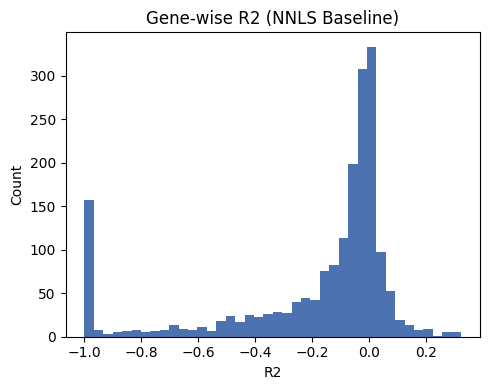

In [9]:
# ==== 可视化基因层面 R2 分布 (基线) ====
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
vals = df_nnls_gene.R2_NNLS.dropna().clip(-1,1)
plt.hist(vals, bins=40, color="#4C72B0")
plt.title("Gene-wise R2 (NNLS Baseline)")
plt.xlabel("R2")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

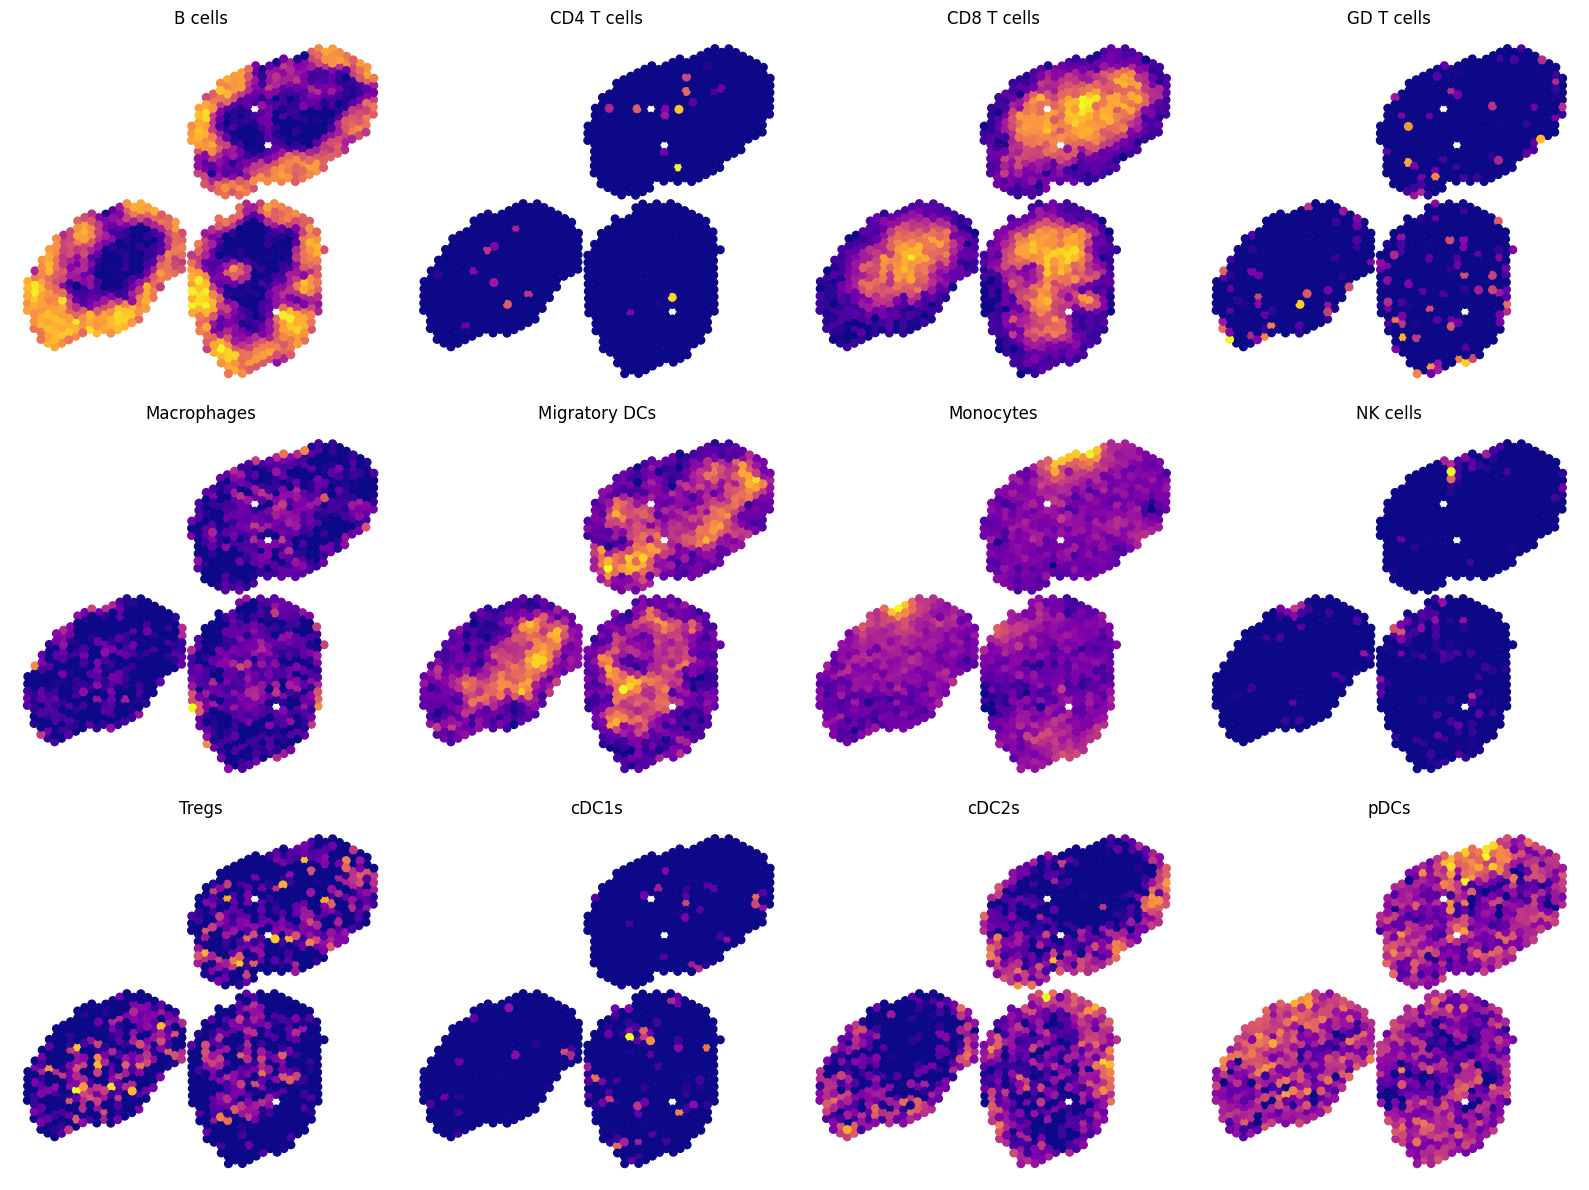

In [13]:
import math
import matplotlib.pyplot as plt

n_types = len(celltypes)
n_cols = 4
n_rows = math.ceil(n_types / n_cols)
coords = ST.obsm["spatial"]  # shape: [n_spots, 2]
plt.figure(figsize=(4 * n_cols, 4 * n_rows))
for i, ct in enumerate(celltypes):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(coords[:, 1], coords[:, 0], c=W_nnls[:, i], s=30, cmap='plasma')
    plt.title(ct)
    plt.axis('off')
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [15]:
# ==== DestVI 基线（基于你当前 _destvi.py 实现） ====
import scvi

# 1. 复制数据
scRNA_dest = scRNA.copy()
ST_dest = ST.copy()

# 2. 训练 CondSCVI（注意：不是 SCVI）
scvi.model.CondSCVI.setup_anndata(
    scRNA_dest,
    layer="counts",
    labels_key="broad_cell_types",
)
sc_model = scvi.model.CondSCVI(scRNA_dest)
sc_model.train(max_epochs=200, batch_size=256)

# 3. 设置 ST anndata
scvi.model.DestVI.setup_anndata(
    ST_dest,
    layer="counts",
)

# 4. 用 from_rna_model 构建 DestVI（而不是直接 __init__）
destvi_model = scvi.model.DestVI.from_rna_model(
    st_adata=ST_dest,
    sc_model=sc_model,     # 必须是 CondSCVI
    l1_reg=0.0,            # 可按需调整
    # vamp_prior_p=15,     # 需要时可改
)

# 5. 训练
destvi_model.train(max_epochs=250)

# 6. 取比例并对齐
proportions_df = destvi_model.get_proportions()
proportions_df = proportions_df.reindex(columns=celltypes)  # 统一顺序
P_destvi = proportions_df.to_numpy()
P_destvi = np.clip(P_destvi, 0, None)
P_destvi = P_destvi / (P_destvi.sum(1, keepdims=True) + 1e-8)

# 7. 重建与评估
X_recon_destvi = P_destvi @ E_simple
r2_destvi_global, df_destvi_gene = evaluate_reconstruction(X_st_log, X_recon_destvi, gene_names, "DestVI")

print(f"[DestVI] 全局重建 R2: {r2_destvi_global:.4f}")
print(df_destvi_gene.R2_DestVI.describe())

df_baselines = pd.concat([
    df_baselines,
    pd.DataFrame({
        "method": ["DestVI"],
        "global_R2": [r2_destvi_global],
        "mean_gene_R2": [np.nanmean(df_destvi_gene.R2_DestVI)],
        "median_gene_R2": [np.nanmedian(df_destvi_gene.R2_DestVI)],
    })
], ignore_index=True)

df_baselines

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|██████████| 200/200 [02:35<00:00,  1.24it/s, v_num=1, train_loss_step=856, train_loss_epoch=847]      

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:35<00:00,  1.28it/s, v_num=1, train_loss_step=856, train_loss_epoch=847]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 250/250: 100%|██████████| 250/250 [00:36<00:00,  6.86it/s, v_num=1, train_loss_step=2.04e+6, train_loss_epoch=2.02e+6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [00:36<00:00,  6.84it/s, v_num=1, train_loss_step=2.04e+6, train_loss_epoch=2.02e+6]
[DestVI] 全局重建 R2: 0.3514
count    1888.000000
mean       -0.827026
std         5.408288
min      -122.775528
25%        -0.305371
50%        -0.076258
75%        -0.018402
max         0.003854
Name: R2_DestVI, dtype: float64


,method,global_R2,mean_gene_R2,median_gene_R2
0,NNLS_pseudo_bulk,0.386448,-0.803229,-0.052796
1,DestVI,0.351416,-0.827026,-0.076258


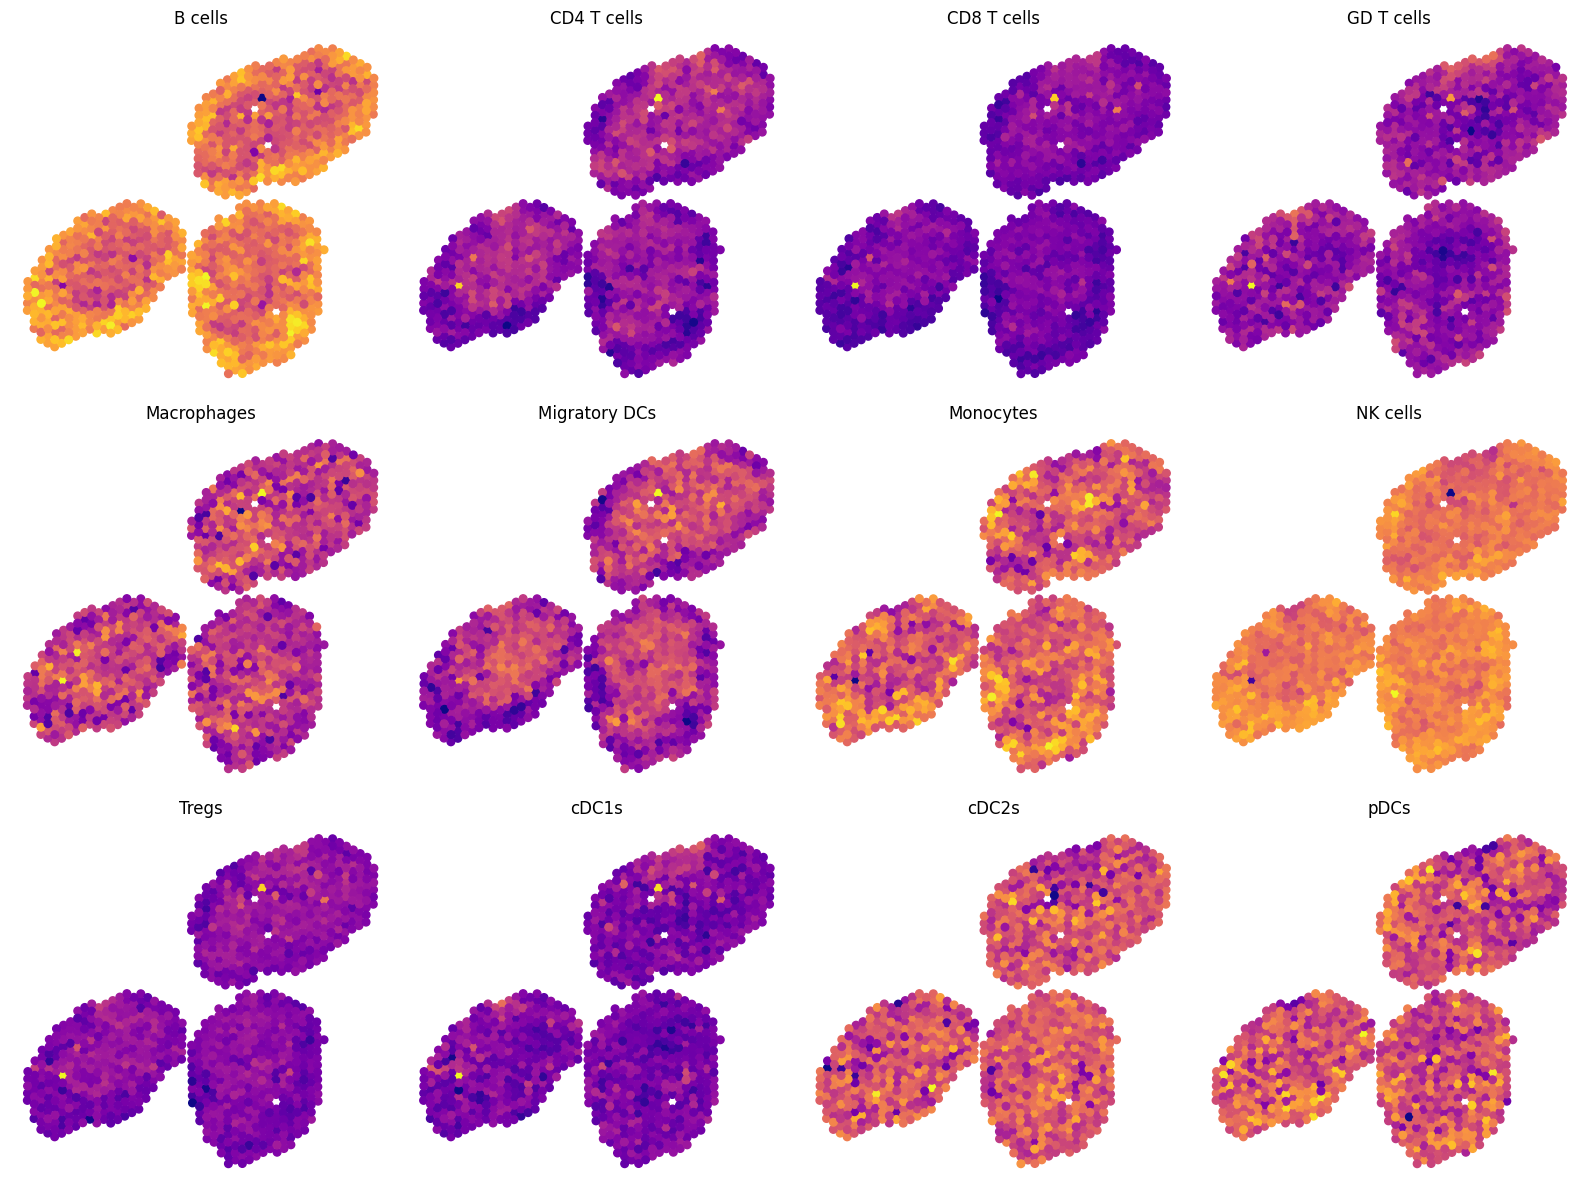

In [16]:
import math
import matplotlib.pyplot as plt

n_types = len(celltypes)
n_cols = 4
n_rows = math.ceil(n_types / n_cols)
coords = ST.obsm["spatial"]  # shape: [n_spots, 2]
plt.figure(figsize=(4 * n_cols, 4 * n_rows))
for i, ct in enumerate(celltypes):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(coords[:, 1], coords[:, 0], c=P_destvi[:, i], s=30, cmap='plasma')
    plt.title(ct)
    plt.axis('off')
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
# ==== 综合结果保存 ====
df_baselines.to_csv("baseline_comparison.csv", index=False)
print("保存 baseline_comparison.csv")

保存 baseline_comparison.csv


In [18]:
marker_dict = {
    "B cells": ["MS4A1", "CD19", "CD79A"],
    "T-cell": ["CD3D", "CD3E", "CD2"], # 通用 T 细胞 Marker
    "CD4 T cells": ["CD4", "IL7R"],
    "CD8 T cells": ["CD8A", "CD8B"],
    "Monocytes": ["CD14", "CSF1R", "CCR2", "LYZ"], # 即使不在当前列表，也先保留
    "cDC1s": ["CLEC9A", "XCR1"],
    "cDC2s": ["CD1C", "SIRPA"],
    "pDCs": ["SIGLECH", "LILRA4", "IRF7"],
    "NK cells": ["NKG7", "GZMB", "KLRF1"],
    "Plasma": ["SDC1", "JCHAIN", "IGHG1"],
    "Tregs": ["FOXP3", "IL2RA"],
    # 其他在您报告中出现的类型，如果需要可以补充
    "GD T cells": ["TRDC", "TRGC1", "TRGC2"],
    "Macrophages": ["CD68", "CD163"],
    "Migratory DCs": ["CCR7", "LAMP3"]
}

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# 假设 E, pred_matrix, celltypes, genes, ST, marker_dict 已准备好
def diagnostic_report(pred_matrix, output_filename, celltypes, genes, ST, E, marker_dict):
    results = []
    with open(output_filename, 'w') as f:
        f.write("="*50 + "\n")
        f.write("全面诊断报告 (版本 2)\n")
        f.write("="*50 + "\n")

        for i, cell_type in enumerate(celltypes):
            f.write(f"\n--- 正在诊断: {cell_type} ---\n")
            # 1. VAE表达谱诊断
            E_vec = E[i, :]
            top_20_indices = np.argsort(E_vec)[-20:]
            top_20_genes_vae = [genes[j] for j in top_20_indices]
            known_markers = marker_dict.get(cell_type, [])
            if "T cell" in cell_type:
                known_markers = known_markers + marker_dict.get("T-cell", [])
            matched_markers_in_vae = [g for g in known_markers if g.lower() in (gene.lower() for gene in top_20_genes_vae)]
            f.write(f"Top 20 基因: {top_20_genes_vae}\n")
            f.write(f"在 Top 20 中找到的 Marker: {matched_markers_in_vae} ({len(matched_markers_in_vae)}/{len(known_markers)})\n")

            # 2. 预测结果与 Marker 基因相关性
            cell_type_pred = pred_matrix[:, i]
            if not known_markers:
                f.write("未找到该细胞类型的已知 Marker，跳过相关性分析。\n")
                results.append({
                    "Cell Type": cell_type,
                    "VAE Top Markers": f"{len(matched_markers_in_vae)}/{len(known_markers)}",
                    "Best Marker": "N/A",
                    "Pearson r": np.nan,
                    "P-value": np.nan
                })
                continue

            best_r = -np.inf
            best_p = 1
            best_marker = ""
            print(f"cell_type_pred.shape={cell_type_pred.shape}, ST shape={ST.shape}")
            for marker_gene in known_markers:
                found_gene = next((g for g in ST.var_names if g.lower() == marker_gene.lower()), None)
                if found_gene is None:
                    continue
                # 关键：用 [found_gene] 保证 shape 正确
                Xg_mat = ST[:, [found_gene]].X
                if hasattr(Xg_mat, "toarray"):
                    Xg = Xg_mat.toarray().ravel()
                elif hasattr(Xg_mat, "A"):
                    Xg = Xg_mat.A.ravel()
                else:
                    Xg = np.asarray(Xg_mat).ravel()
                print(f"marker_gene={marker_gene}, found_gene={found_gene}, Xg.shape={Xg.shape}, cell_type_pred.shape={cell_type_pred.shape}")
                if Xg.shape[0] != cell_type_pred.shape[0]:
                    f.write(f"  跳过: marker {marker_gene} ({found_gene}) 表达 {Xg.shape[0]}，预测 {cell_type_pred.shape[0]}\n")
                    continue
                r, p = pearsonr(Xg, cell_type_pred)
                f.write(f"  与 {found_gene} ({marker_gene}) 的相关性: r={r:.3f}, p={p:.2e}\n")
                if r > best_r:
                    best_r = r
                    best_p = p
                    best_marker = found_gene

            results.append({
                "Cell Type": cell_type,
                "VAE Top Markers": f"{len(matched_markers_in_vae)}/{len(known_markers)}",
                "Best Marker": best_marker,
                "Pearson r": best_r,
                "P-value": best_p
            })

        f.write("\n\n" + "="*50 + "\n")
        f.write("诊断总结报告\n")
        f.write("="*50 + "\n")
        results_df = pd.DataFrame(results)
        f.write(results_df.to_string())

    print(f"诊断报告已成功保存到文件: {output_filename}")

# 用法示例
diagnostic_report(W_nnls, "diagnostic_NNLS.txt", celltypes, genes, ST, E_simple, marker_dict)
diagnostic_report(P_destvi, "diagnostic_destvi.txt", celltypes, genes, ST, E_simple, marker_dict)

cell_type_pred.shape=(1092,), ST shape=(1092, 1888)
marker_gene=MS4A1, found_gene=Ms4a1, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
marker_gene=CD79A, found_gene=Cd79a, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
cell_type_pred.shape=(1092,), ST shape=(1092, 1888)
marker_gene=CD4, found_gene=Cd4, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
marker_gene=IL7R, found_gene=Il7r, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
marker_gene=CD3D, found_gene=Cd3d, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
marker_gene=CD3E, found_gene=Cd3e, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
cell_type_pred.shape=(1092,), ST shape=(1092, 1888)
marker_gene=CD8A, found_gene=Cd8a, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
marker_gene=CD3D, found_gene=Cd3d, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
marker_gene=CD3E, found_gene=Cd3e, Xg.shape=(1092,), cell_type_pred.shape=(1092,)
cell_type_pred.shape=(1092,), ST shape=(1092, 1888)
marker_gene=TRDC, found_gene=Trdc, Xg.shape=(1092,),